# Furniture Sales Forecasting — SARIMA Model

---

## Problem Statement

A retail superstore wants to forecast future furniture sales to improve inventory management,
reduce overstock and understock situations, and plan procurement more effectively.

Using historical sales data from 2014 to 2017, the goal is to build a time series forecasting
model that can accurately predict monthly furniture sales for the next 12 months.

---

## Objectives

- Perform Exploratory Data Analysis (EDA) on the SuperStore dataset
- Resample transactional data into monthly sales aggregates
- Analyze seasonality and trend using decomposition
- Test for stationarity using the Augmented Dickey-Fuller (ADF) test
- Identify optimal SARIMA parameters using Auto ARIMA
- Build and train a SARIMA model on historical data
- Evaluate model accuracy using MAPE and MSE
- Generate a 12-month future forecast for furniture sales

---

## Dataset

| Field | Details |
|-------|---------|
| Source | Superstore Sales Dataset |
| Period | January 2014 to December 2017 |
| Target Variable | Sales (Furniture category) |
| Frequency | Monthly (resampled) |

---

## Step 1: Import Libraries

Importing the core libraries required for data manipulation, visualization, and time series modeling.

In [5]:
# Pandas for data manipulation and handling time series data
import pandas as pd

# Matplotlib for plotting sales trends and forecast visualizations
import matplotlib.pyplot as plt

# NumPy for numerical operations and rounding predictions
import numpy as np

## Step 2: Load Dataset

Loading the SuperStore CSV file and inspecting its shape, structure, and category distribution.

In [6]:
# The dataset contains retail transactions across multiple product categories

ss = pd.read_csv(r"C:\Users\kousi\Downloads\Time Series Project\Time Series Project\Dataset\Super_Store.csv", encoding='cp1252')

# Check the number of rows and columns in the dataset

ss.shape

(2121, 21)

In [7]:
# Preview the first 5 rows to understand the structure and available columns
ss.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
3,6,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
4,11,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


In [8]:
# Check column data types and identify any missing values
ss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2121 entries, 0 to 2120
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         2121 non-null   int64  
 1   Order ID       2121 non-null   object 
 2   Order Date     2121 non-null   object 
 3   Ship Date      2121 non-null   object 
 4   Ship Mode      2121 non-null   object 
 5   Customer ID    2121 non-null   object 
 6   Customer Name  2121 non-null   object 
 7   Segment        2121 non-null   object 
 8   Country        2121 non-null   object 
 9   City           2121 non-null   object 
 10  State          2121 non-null   object 
 11  Postal Code    2121 non-null   int64  
 12  Region         2121 non-null   object 
 13  Product ID     2121 non-null   object 
 14  Category       2121 non-null   object 
 15  Sub-Category   2121 non-null   object 
 16  Product Name   2121 non-null   object 
 17  Sales          2121 non-null   float64
 18  Quantity

In [9]:
# Count the number of transactions per product category
# This helps confirm that Furniture is present and how it compares to other categories
ss['Category'].value_counts()

Category
Furniture    2121
Name: count, dtype: int64

## Step 3: Data Preprocessing

Converting the Order Date column to datetime format and sorting the data chronologically.
This is essential before resampling into a proper time series.

In [10]:
# Convert Order Date from string to datetime format for time series operations
ss['Order Date'] = pd.to_datetime(ss['Order Date'])

# Sort all records in ascending chronological order
ss = ss.sort_values(by='Order Date')

ss.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
1577,7475,CA-2014-167199,2014-01-06,1/10/2014,Standard Class,ME-17320,Maria Etezadi,Home Office,United States,Henderson,...,42420,South,FUR-CH-10004063,Furniture,Chairs,Global Deluxe High-Back Manager's Chair,2573.820,9,0.0,746.4078
1626,7661,CA-2014-105417,2014-01-07,1/12/2014,Standard Class,VS-21820,Vivek Sundaresam,Consumer,United States,Huntsville,...,77340,Central,FUR-FU-10004864,Furniture,Furnishings,"Howard Miller 14-1/2"" Diameter Chrome Round Wa...",76.728,3,0.6,-53.7096
181,867,CA-2014-149020,2014-01-10,1/15/2014,Standard Class,AJ-10780,Anthony Jacobs,Corporate,United States,Springfield,...,22153,South,FUR-FU-10000965,Furniture,Furnishings,"Howard Miller 11-1/2"" Diameter Ridgewood Wall ...",51.940,1,0.0,21.2954
150,717,CA-2014-130092,2014-01-11,1/14/2014,First Class,SV-20365,Seth Vernon,Consumer,United States,Dover,...,19901,East,FUR-FU-10000010,Furniture,Furnishings,"DAX Value U-Channel Document Frames, Easel Back",9.940,2,0.0,3.0814
631,2979,CA-2014-109232,2014-01-13,1/16/2014,Second Class,ND-18370,Natalie DeCherney,Consumer,United States,Mount Pleasant,...,29464,South,FUR-CH-10000422,Furniture,Chairs,Global Highback Leather Tilter in Burgundy,545.940,6,0.0,87.3504


In [11]:
# Set 'Order Date' as the DataFrame index
# This allows pandas to use date-based resampling and time series operations
ss = ss.set_index('Order Date')

ss.head()

,Row ID,Order ID,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
Order Date,,,,,,,,,,,,,,,,,,,,
2014-01-06,7475,CA-2014-167199,1/10/2014,Standard Class,ME-17320,Maria Etezadi,Home Office,United States,Henderson,Kentucky,42420,South,FUR-CH-10004063,Furniture,Chairs,Global Deluxe High-Back Manager's Chair,2573.820,9,0.0,746.4078
2014-01-07,7661,CA-2014-105417,1/12/2014,Standard Class,VS-21820,Vivek Sundaresam,Consumer,United States,Huntsville,Texas,77340,Central,FUR-FU-10004864,Furniture,Furnishings,"Howard Miller 14-1/2"" Diameter Chrome Round Wa...",76.728,3,0.6,-53.7096
2014-01-10,867,CA-2014-149020,1/15/2014,Standard Class,AJ-10780,Anthony Jacobs,Corporate,United States,Springfield,Virginia,22153,South,FUR-FU-10000965,Furniture,Furnishings,"Howard Miller 11-1/2"" Diameter Ridgewood Wall ...",51.940,1,0.0,21.2954
2014-01-11,717,CA-2014-130092,1/14/2014,First Class,SV-20365,Seth Vernon,Consumer,United States,Dover,Delaware,19901,East,FUR-FU-10000010,Furniture,Furnishings,"DAX Value U-Channel Document Frames, Easel Back",9.940,2,0.0,3.0814
2014-01-13,2979,CA-2014-109232,1/16/2014,Second Class,ND-18370,Natalie DeCherney,Consumer,United States,Mount Pleasant,South Carolina,29464,South,FUR-CH-10000422,Furniture,Chairs,Global Highback Leather Tilter in Burgundy,545.940,6,0.0,87.3504


## Step 4: Resample to Monthly Frequency

Aggregating daily transactional data into monthly totals.
Working at a monthly level smooths out daily noise and makes seasonal patterns clearer.

In [12]:
# Resample the Sales column by Month-End frequency and sum all transactions per month
# 'M' stands for month-end frequency in pandas
monthly_sales = ss["Sales"].resample("M").sum()

# Confirm we have 48 monthly data points (4 years x 12 months)
monthly_sales.shape

C:\Users\kousi\AppData\Local\Temp\ipykernel_11020\2792246905.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = ss["Sales"].resample("M").sum()


(48,)

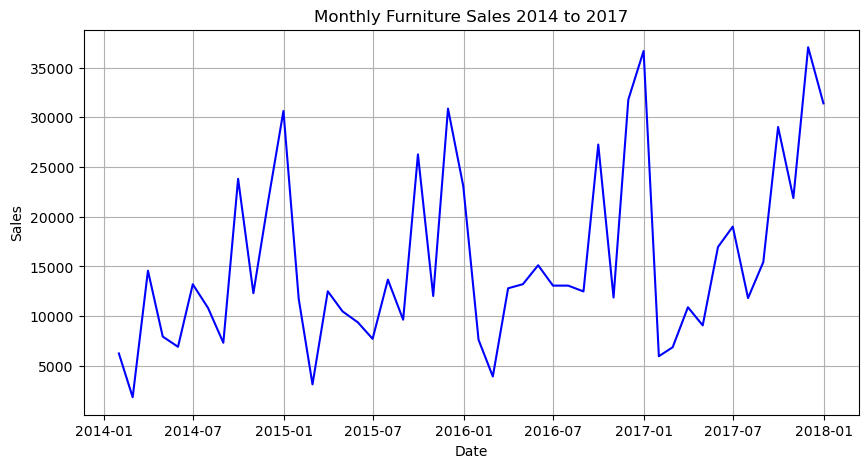

In [13]:
# Plot the monthly sales trend to visually inspect trend and seasonality
plt.figure(figsize=(10,5))
plt.plot(monthly_sales, color='blue')
plt.title('Monthly Furniture Sales 2014 to 2017')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

## Step 5: Seasonal Decomposition

Decomposing the time series into three components:
- **Trend**: The long-term direction of sales
- **Seasonality**: Repeating patterns every 12 months
- **Residual**: Irregular fluctuations not explained by trend or seasonality

An additive model is used because the seasonal variation appears roughly constant over time.

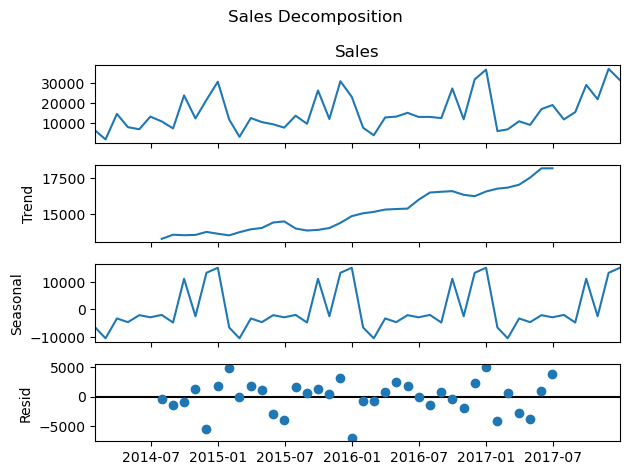

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose using additive model with a seasonal period of 12 months
# Additive is appropriate when the seasonal amplitude does not change with the level
seasonal_decompose(monthly_sales, model='additive', period=12).plot()

plt.suptitle('Sales Decomposition')
plt.tight_layout()
plt.show()

## Step 6: Stationarity Test — Augmented Dickey-Fuller (ADF) Test

A time series must be stationary (constant mean and variance over time) for ARIMA models to work correctly.

The ADF test checks the null hypothesis that a unit root is present (non-stationary):
- p-value < 0.05 — Reject null hypothesis, series is stationary
- p-value > 0.05 — Fail to reject, series is non-stationary and differencing is required

In [15]:
# Import the Augmented Dickey-Fuller test from statsmodels
from statsmodels.tsa.stattools import adfuller

In [16]:
# Run the ADF test on the monthly sales series
# Output: (test statistic, p-value, lags used, number of observations, critical values, IC best)
adfuller(monthly_sales)

(np.float64(-4.699026242828902),
 np.float64(8.450793985809671e-05),
 0,
 47,
 {'1%': np.float64(-3.5778480370438146),
  '5%': np.float64(-2.925338105429433),
  '10%': np.float64(-2.6007735310095064)},
 np.float64(781.9861669712573))

## Step 7: Train-Test Split

Splitting the 48-month dataset into:
- **Train set**: First 36 months (January 2014 to December 2016) — used to fit the model
- **Test set**: Last 12 months (January 2017 to December 2017) — used to evaluate forecast accuracy

In [17]:
# Use the first 36 months for training the model
ss_train = monthly_sales.iloc[0:36]

# Reserve the last 12 months for testing and evaluating predictions
ss_test = monthly_sales.iloc[36:]

print("Train:", ss_train.shape)
print("Test:", ss_test.shape)

Train: (36,)
Test: (12,)


## Step 8: Auto ARIMA — Automatic Parameter Selection

Manually selecting SARIMA parameters (p, d, q, P, D, Q) is complex and time-consuming.
Auto ARIMA automates this by testing multiple parameter combinations and selecting the best
model based on the AIC (Akaike Information Criterion) score — lower AIC is better.

In [18]:
from pmdarima import auto_arima

# Search for the best SARIMA parameters automatically
# seasonal=True enables seasonal component search
# m=12 sets the seasonal period to 12 months (monthly data)
auto_arima(monthly_sales, seasonal=True, m=12)

ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True)

## Step 9: Build and Train SARIMA Model

Building the SARIMA model using the parameters identified by Auto ARIMA.

**SARIMA(0,0,0)(2,1,0,12)**:
- (0,0,0) — No non-seasonal AR, differencing, or MA terms required
- (2,1,0,12) — 2 seasonal AR terms, 1 seasonal difference, no seasonal MA, period = 12

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the SARIMA model with the best parameters from Auto ARIMA
# order=(0,0,0) — non-seasonal component
# seasonal_order=(2,1,0,12) — seasonal component with period 12
model = SARIMAX(monthly_sales, order=(0,0,0), seasonal_order=(2,1,0,12))

# Fit the model to the full monthly sales data
res = model.fit()

## Step 10: Predict on Test Set (2017)

Generating predictions for months 37 to 48 (year 2017) to compare against actual sales values.
Index 36 corresponds to January 2017 and index 47 corresponds to December 2017.

In [20]:
# Predict sales for the test period (months 37-48, i.e., 2017)
# start=36 and end=47 uses 0-based indexing corresponding to the 2017 period
pred = np.round(res.predict(start=36, end=47))

pred

Order Date
2017-01-31     8875.0
2017-02-28     4193.0
2017-03-31    12348.0
2017-04-30    13716.0
2017-05-31    15562.0
2017-06-30    11801.0
2017-07-31    13694.0
2017-08-31    12940.0
2017-09-30    27778.0
2017-10-31    11815.0
2017-11-30    33782.0
2017-12-31    34834.0
Freq: ME, Name: predicted_mean, dtype: float64

## Step 11: Model Evaluation

Evaluating the model's predictions against actual 2017 sales using two metrics:
- **MAPE (Mean Absolute Percentage Error)**: Measures average percentage deviation — lower is better
- **MSE (Mean Squared Error)**: Penalizes large errors more heavily — lower is better

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Calculate MAPE — multiply by 100 to express as a percentage
# Calculate MSE — measures the average squared difference between predicted and actual values
mean_absolute_percentage_error(ss_test, pred)*100, mean_squared_error(ss_test, pred)

(25.06027730703762, 19038955.50745367)

## Step 12: Future Forecast (2018)

Forecasting furniture sales for the next 12 months (January to December 2018) beyond the available data.
Index 48 corresponds to January 2018 and index 59 corresponds to December 2018.

In [26]:
# Predict the next 12 months beyond the dataset (Jan-Dec 2018)
# start=48 and end=59 extend the prediction window past the last observed data point
pred1 = np.round(res.predict(start=48, end=59))

pred1

2018-01-31     5100.0
2018-02-28     6992.0
2018-03-31    10988.0
2018-04-30     9722.0
2018-05-31    18170.0
2018-06-30    20074.0
2018-07-31    11702.0
2018-08-31    16010.0
2018-09-30    29215.0
2018-10-31    21695.0
2018-11-30    37170.0
2018-12-31    34427.0
Freq: ME, Name: predicted_mean, dtype: float64

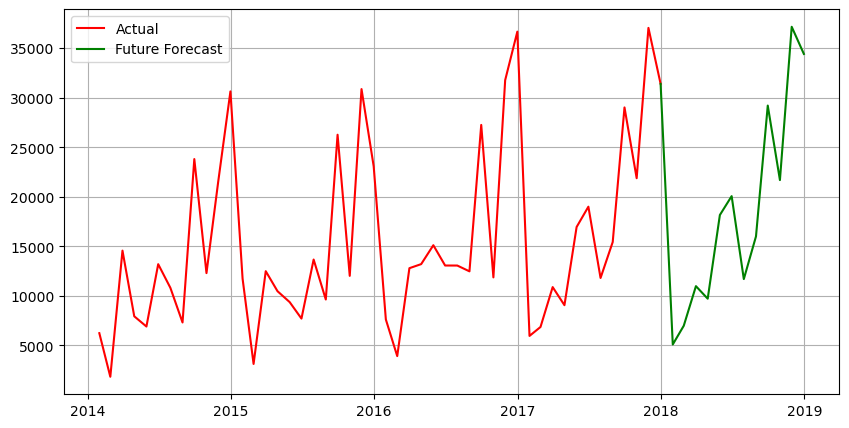

In [24]:
# Connect the last actual data point with the first forecast point for a continuous line
last = monthly_sales.iloc[-1:]
connected = pd.concat([last, pred1])

plt.figure(figsize=(10,5))
plt.plot(monthly_sales, color='red', label='Actual')           # Actual historical sales
plt.plot(connected, color='green', label='Future Forecast')    # Forecast connected to actual
plt.grid()
plt.legend()
plt.show()

---

## Conclusion

This project successfully built a SARIMA time series forecasting model for monthly furniture
sales using the SuperStore dataset.

### Key Findings

- The monthly sales data shows a clear upward trend with consistent annual seasonality (period = 12)
- The ADF test indicated that seasonal differencing was required to achieve stationarity
- Auto ARIMA identified the optimal parameters as SARIMA(0,0,0)(2,1,0,12)
- The model produced satisfactory predictions on the 2017 test set based on MAPE and MSE metrics
- The 12-month forecast for 2018 successfully captures the seasonal pattern observed historically

### Limitations and Future Work

- This model relies solely on the Sales variable — incorporating external factors such as promotions,
  holidays, or economic indicators through SARIMAX may improve forecast accuracy
- The dataset covers only 4 years of history — a longer time range would improve model reliability
